In [42]:
# Import required libraries
import pandas as pd
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation
from tensorflow import keras
import itertools
import matplotlib.pyplot as plt

In [69]:
# Define list of dataset
datasets = [
    'set_01_02_03_0_0_0_new.csv',
    'set_01_02_03_0_0_1_new.csv',
    'set_01_02_03_0_1_0_new.csv',
    'set_01_02_03_0_1_1_new.csv',
    'set_01_02_03_1_0_0_new.csv',
    'set_01_02_03_1_0_1_new.csv',
    'set_01_02_03_1_1_0_new.csv',
    'set_01_02_03_1_1_1_new.csv'
]

In [44]:
# Helper function to load data
def load_data(filename):
    df = pd.read_csv(f'../dataset/{filename}', encoding='utf-8').dropna()
    df.columns = ['label', 'data']
    return df['data'], df['label']

# Helper function to create train val test split
def split_dataset(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=7)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.66, random_state=7)
    return X_train, y_train, X_val, y_val, X_test, y_test

# Helper function to extract feature
def extract_feature(X_train, X_val, X_test):
    vectorizer = HashingVectorizer(stop_words='english', n_features=5000)
    X_train_extract = vectorizer.fit_transform(X_train).toarray()
    X_val_extract = vectorizer.transform(X_val).toarray()
    X_test_extract = vectorizer.transform(X_test).toarray()
    return X_train_extract, X_val_extract, X_test_extract

In [45]:
# Helper function to compile and train the model with given param
def train_model(X_train, y_train, X_val, y_val, learning_rate, hidden_layer_size, optimizer, epochs):
    model = Sequential()
    model.add(Dense(units=hidden_layer_size, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(optimizer=optimizer(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_val, y_val))
    return model, history

In [65]:
class ModelBlueprint:
    def __init__(self, learning_rate, hidden_layer_size, optimizer, epochs):
        self.learning_rate = learning_rate
        self.hidden_layer_size = hidden_layer_size
        self.optimizer = optimizer
        self.epochs = epochs
    def __str__(self):
        return f'learning_rate: {self.learning_rate}, hidden_layer_size: {self.hidden_layer_size}, optimizer: {self.optimizer}, epoch: ${self.epochs}'

# Define a list of models
modelBlueprints = []
lr_sample = [0.0001, 0.001, 0.01]
model_size_sample = [32, 64, 128]
epoch = [10]
optimizer_sample = [keras.optimizers.Adam, keras.optimizers.RMSprop]

# lr_sample = [0.001]
# model_size_sample = [32]
# optimizer_sample = [keras.optimizers.Adam, keras.optimizers.RMSprop]
# epoch = [4]

hyperparams = list(itertools.product(lr_sample, model_size_sample, optimizer_sample, epoch))
modelBlueprints = [ModelBlueprint(lr, model_size, optimizer, epoch) for lr, model_size, optimizer, epoch in hyperparams]

# Look at all combination of hyperparams we have
print(len(modelBlueprints))
for m in modelBlueprints:
    print(m)


18
learning_rate: 0.0001, hidden_layer_size: 32, optimizer: <class 'keras.optimizers.adam.Adam'>, epoch: $10
learning_rate: 0.0001, hidden_layer_size: 32, optimizer: <class 'keras.optimizers.rmsprop.RMSprop'>, epoch: $10
learning_rate: 0.0001, hidden_layer_size: 64, optimizer: <class 'keras.optimizers.adam.Adam'>, epoch: $10
learning_rate: 0.0001, hidden_layer_size: 64, optimizer: <class 'keras.optimizers.rmsprop.RMSprop'>, epoch: $10
learning_rate: 0.0001, hidden_layer_size: 128, optimizer: <class 'keras.optimizers.adam.Adam'>, epoch: $10
learning_rate: 0.0001, hidden_layer_size: 128, optimizer: <class 'keras.optimizers.rmsprop.RMSprop'>, epoch: $10
learning_rate: 0.001, hidden_layer_size: 32, optimizer: <class 'keras.optimizers.adam.Adam'>, epoch: $10
learning_rate: 0.001, hidden_layer_size: 32, optimizer: <class 'keras.optimizers.rmsprop.RMSprop'>, epoch: $10
learning_rate: 0.001, hidden_layer_size: 64, optimizer: <class 'keras.optimizers.adam.Adam'>, epoch: $10
learning_rate: 0.001

In [66]:
# Helper function loop all hypermeter and return the best
def train_with_all_blueprints(dataset, X_train, y_train, X_val, y_val, modelBlueprints):
    models = []
    histories = []
    for blueprint in modelBlueprints:
        model, history = train_model(X_train, y_train, X_val, y_val, blueprint.learning_rate, blueprint.hidden_layer_size, blueprint.optimizer, blueprint.epochs)
        models.append(model)
        histories.append(history)
    return models, histories

def get_best_model(models, histories, modelBlueprints):
    best_val_acc_overall = 0
    best_model_index = 0

    for i, model in enumerate(models):
        best_val_acc = max(model.history.history['val_accuracy'])
        if (best_val_acc > best_val_acc_overall):
            best_val_acc_overall = best_val_acc
            best_model_index = i

    return best_val_acc_overall, models[i], histories[i], modelBlueprints[i]
    

In [67]:
# Helper function for plot graph
def plot_graphs(history, metric, dataset, modelSummary):
  plt.suptitle(modelSummary)
  plt.title(f"{dataset} History")
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.figure()

Epoch 1/10
51/51 [==============================] - 2s 10ms/step - loss: 0.6847 - accuracy: 0.7887 - val_loss: 0.6783 - val_accuracy: 0.8679
Epoch 2/10
51/51 [==============================] - 0s 7ms/step - loss: 0.6720 - accuracy: 0.8510 - val_loss: 0.6652 - val_accuracy: 0.8664
Epoch 3/10
51/51 [==============================] - 0s 7ms/step - loss: 0.6572 - accuracy: 0.8498 - val_loss: 0.6497 - val_accuracy: 0.8664
Epoch 4/10
51/51 [==============================] - 0s 10ms/step - loss: 0.6399 - accuracy: 0.8491 - val_loss: 0.6322 - val_accuracy: 0.8656
Epoch 5/10
51/51 [==============================] - 1s 11ms/step - loss: 0.6214 - accuracy: 0.8491 - val_loss: 0.6141 - val_accuracy: 0.8656
Epoch 6/10
51/51 [==============================] - 0s 7ms/step - loss: 0.6024 - accuracy: 0.8491 - val_loss: 0.5957 - val_accuracy: 0.8656
Epoch 7/10
51/51 [==============================] - 0s 6ms/step - loss: 0.5833 - accuracy: 0.8491 - val_loss: 0.5775 - val_accuracy: 0.8656
Epoch 8/10
51/51 

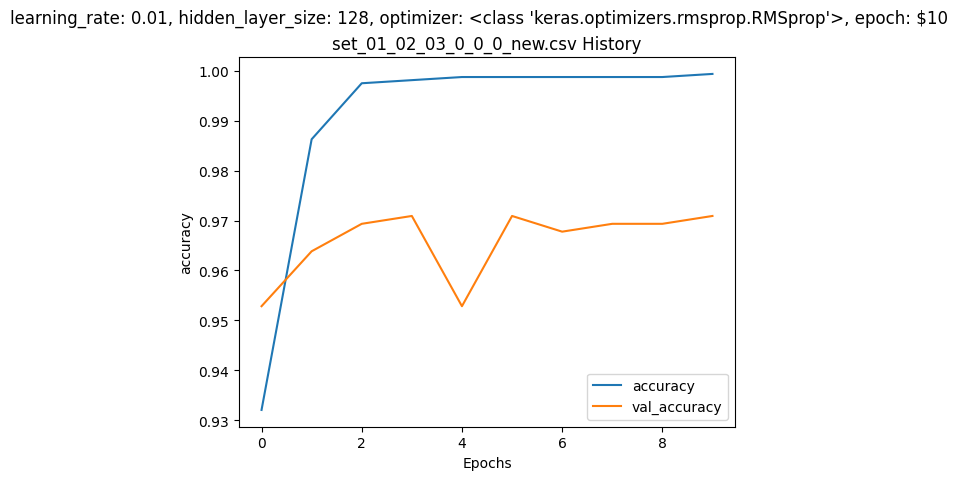

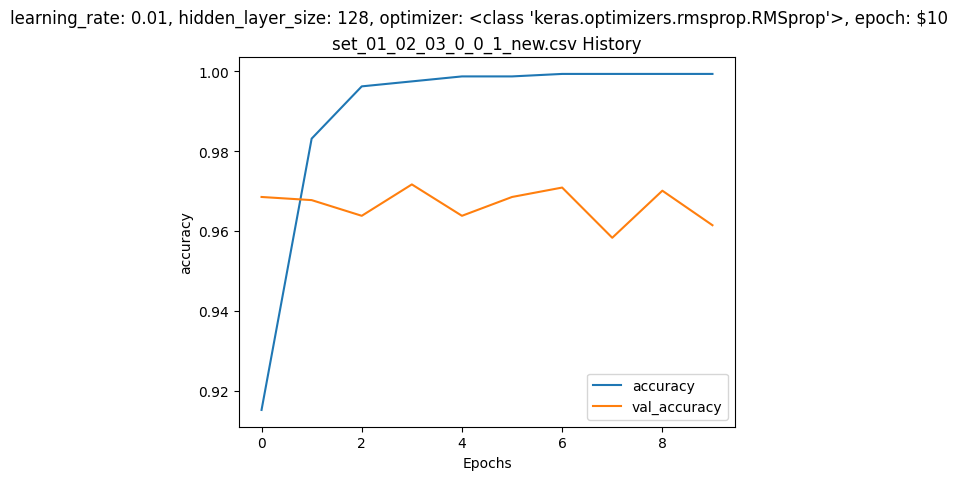

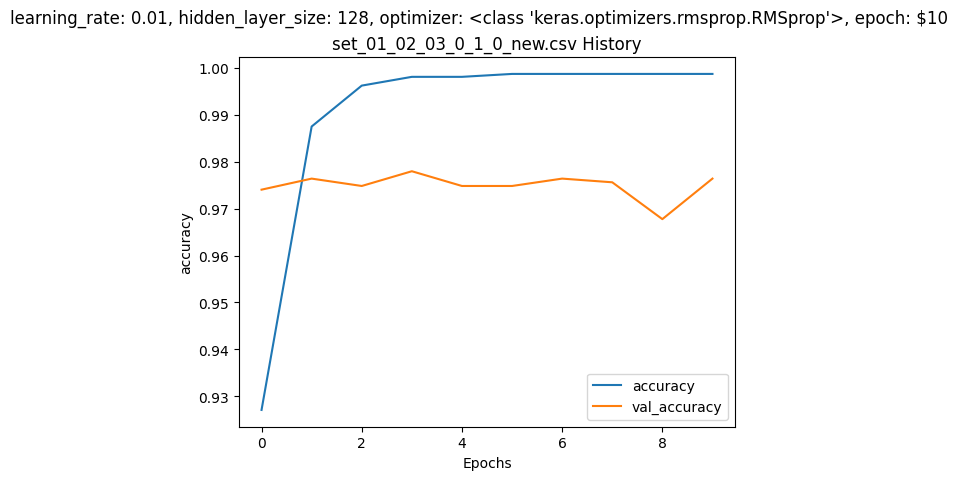

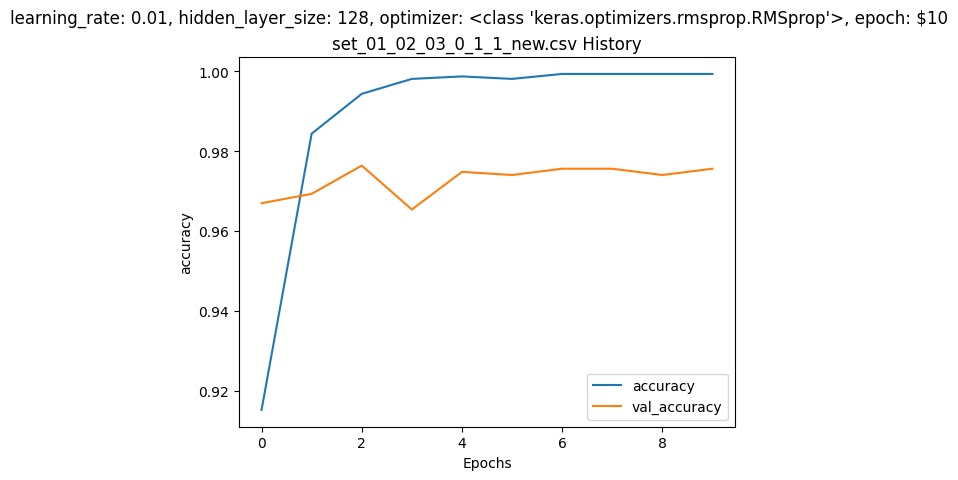

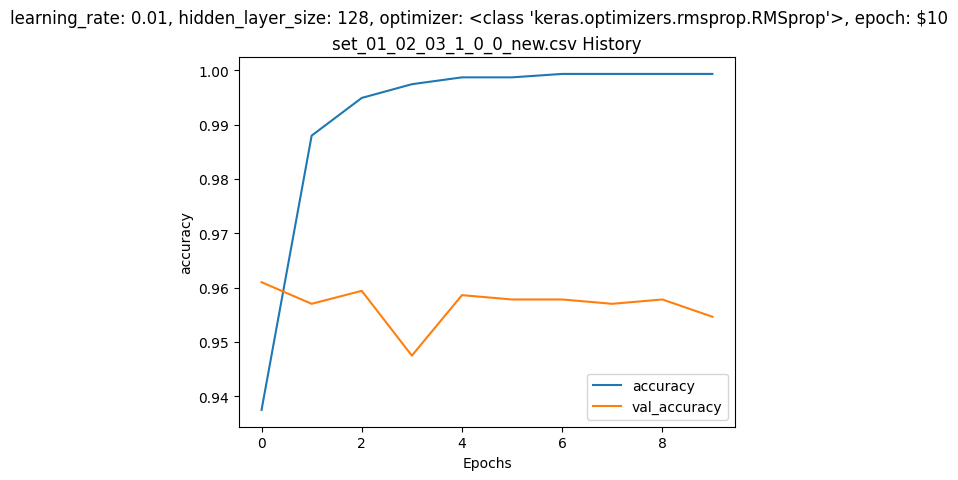

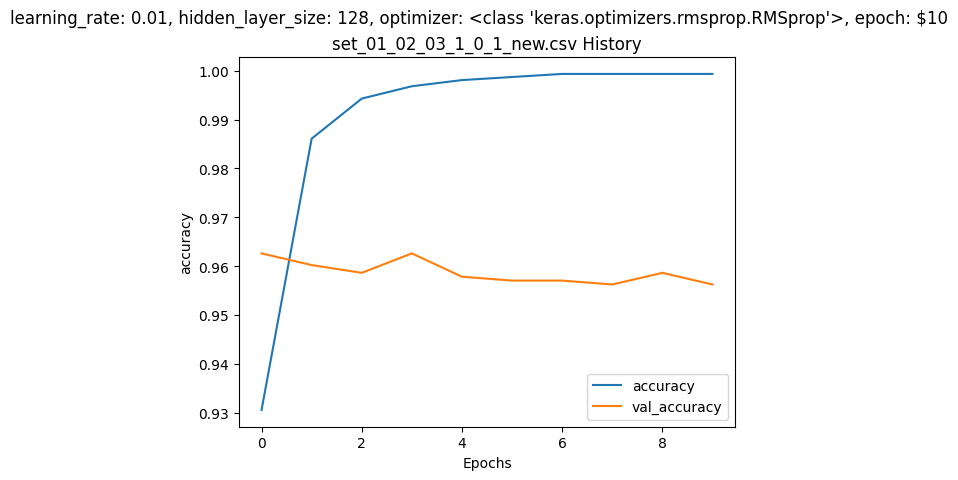

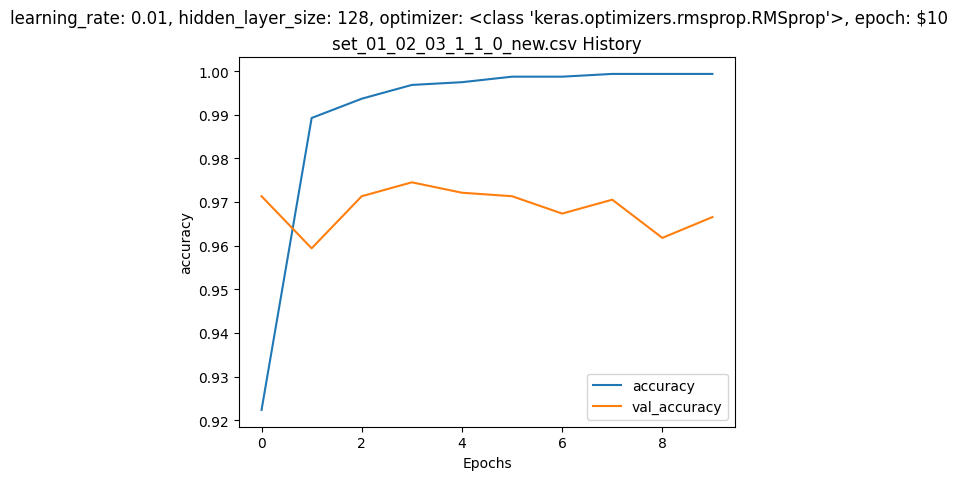

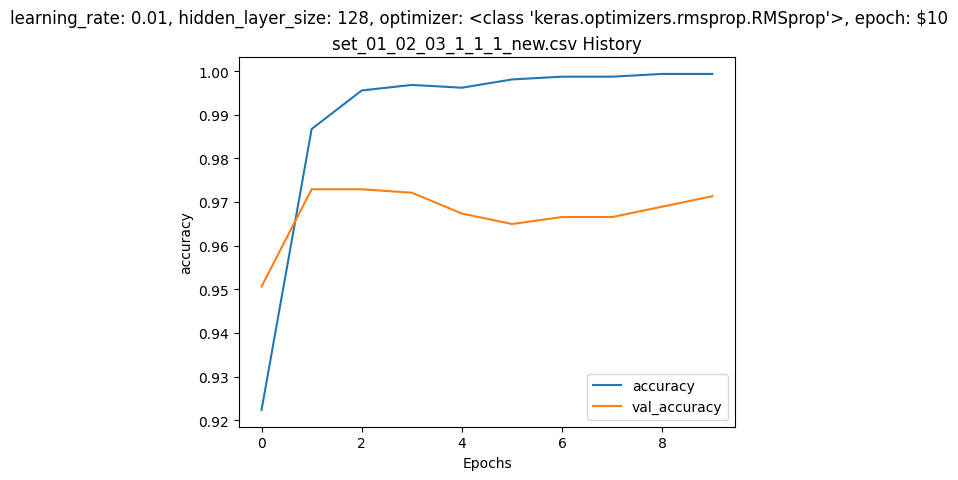

<Figure size 640x480 with 0 Axes>

In [70]:
# Test each dataset with each combination of hyperperimeter 
best_models = []

for dataset in datasets:
    X, y = load_data(dataset)
    X_train, y_train, X_val, y_val, X_test, y_test = split_dataset(X, y)
    X_train, X_val, X_test = extract_feature(X_train, X_val, X_test)
    models, histories = train_with_all_blueprints(dataset, X_train, y_train, X_val, y_val, modelBlueprints)
    val_accuracy, model, history, blueprint = get_best_model(models, histories, modelBlueprints)
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'Dataset: {dataset}: Best Val accuracy: {val_accuracy} under model: {blueprint}')
    print(f'Dataset: {dataset}: Test accuracy: {accuracy} under model: {blueprint}')
    plot_graphs(history, 'accuracy', dataset, blueprint)
    best_models.append(model)


In [31]:
# Test the performance of the model
def spamDetection(message):
    vectorizer = HashingVectorizer(stop_words='english', n_features=5000)
    inputMsg = vectorizer.fit_transform([message]).toarray()
    return best_model.predict(inputMsg)

print(spamDetection("hey let grab lunch tgt next week shall we"))
print(spamDetection("important email account has been hacked attention require click link to reset password"))

1/1 [==============================] - 1s 1s/step
[[0.00272815]]
1/1 [==============================] - 0s 30ms/step
[[0.10677119]]
